In [61]:
from sklearn import svm

from libplot import plot_classification
from functools import lru_cache, partial
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import scipy
from Imitate.datasets import generateData_twoPills_2D, plot_dataset_2D
from tqdm.auto import tqdm
from sklearn import svm, tree, metrics as skmetrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from art.metrics import empirical_robustness
from joblib import delayed, Parallel
from modAL import batch

from libdatasets import *
from librun import run, plot
from libadversarial import poison_secml, random_synthesis, meshgrid_synthesis, uncertainty_synthesis
from libactive import active_split, MyActiveLearner
from libutil import ProgressParallel

## SVM Decision Boundary

In [64]:
from modAL import batch, ActiveLearner
from modAL.uncertainty import uncertainty_sampling
def plot_classification(ax, clf, X, Y, X_all, y_all, clf_all):
    """
    Plot the results of a classifier
    """
    from libplot import make_meshgrid, plot_contours
    
    marker_size = 50
    colours = ['black', 'red', 'green', 'blue']

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X_all[:, 0], X_all[:, 1], h=0.01)

    Z = clf.estimator.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Draw initial boundary
    ax.contour(xx, yy, Z, colors=colours[0], levels=[0], alpha=1,
               linestyles=['-'])
    
    # Draw initial points
    round0 = Line2D([0], [0], color=colours[0], label="Initial round")
    ax.scatter(X0[Y==0], X1[Y==0], s=60, edgecolors="k", marker='^', color=colours[0], label="Positive")
    ax.scatter(X0[Y==1], X1[Y==1], s=60, edgecolors="k", color=colours[0], label="Negative")
    
    chosen = batch.uncertainty_batch_sampling(clf, X_all, 10)
    
    # Draw selected points
    round1 = Line2D([0], [0], color=colours[1], label="1st round")
    ax.scatter(X_all[chosen][y_all[chosen]==0][:,0], X_all[chosen][y_all[chosen]==0][:,1], marker='^', color=colours[1], s=marker_size)
    ax.scatter(X_all[chosen][y_all[chosen]==1][:,0], X_all[chosen][y_all[chosen]==1][:,1], color=colours[1], s=marker_size)
    
    # --------
    
    clf.teach(X_all[chosen], y_all[chosen])
    
    # Draw next boundary
    Z = clf.estimator.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, colors=colours[1], levels=[0], alpha=1,
               linestyles=['-'])
    
    mask = np.ones(len(X_all), bool)
    mask[chosen] = 0
    X_all = X_all[mask]
    y_all = y_all[mask]
    
    chosen = batch.uncertainty_batch_sampling(clf, X_all, 10)
    
    # Draw selected points
    round2 = Line2D([0], [0], color=colours[2], label="2nd round")
    ax.scatter(X_all[chosen][y_all[chosen]==0][:,0], X_all[chosen][y_all[chosen]==0][:,1], marker='^', color=colours[2], s=marker_size)
    ax.scatter(X_all[chosen][y_all[chosen]==1][:,0], X_all[chosen][y_all[chosen]==1][:,1], color=colours[2], s=marker_size)
    
    # --------
    
    clf.teach(X_all[chosen], y_all[chosen])
    
    # Draw next boundary
    Z = clf.estimator.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, colors=colours[2], levels=[0], alpha=1,
               linestyles=['-'])
    
    mask = np.ones(len(X_all), bool)
    mask[chosen] = 0
    X_all = X_all[mask]
    y_all = y_all[mask]
    
    chosen = batch.uncertainty_batch_sampling(clf, X_all, 10)
    
    # Draw selected points
    #ax.scatter(X_all[chosen][y_all[chosen]==0][:,0], X_all[chosen][y_all[chosen]==0][:,1], marker='^', color=colours[3], s=marker_size, label="3rd round")
    #ax.scatter(X_all[chosen][y_all[chosen]==1][:,0], X_all[chosen][y_all[chosen]==1][:,1], color=colours[3], s=marker_size)
    
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    print(ax.get_legend_handles_labels())
    ax.legend(handles=[*ax.get_legend_handles_labels()[0], round0, round1, round2])
    if ax is None:
        return fig

AttributeError: 'NoneType' object has no attribute 'tight_layout'

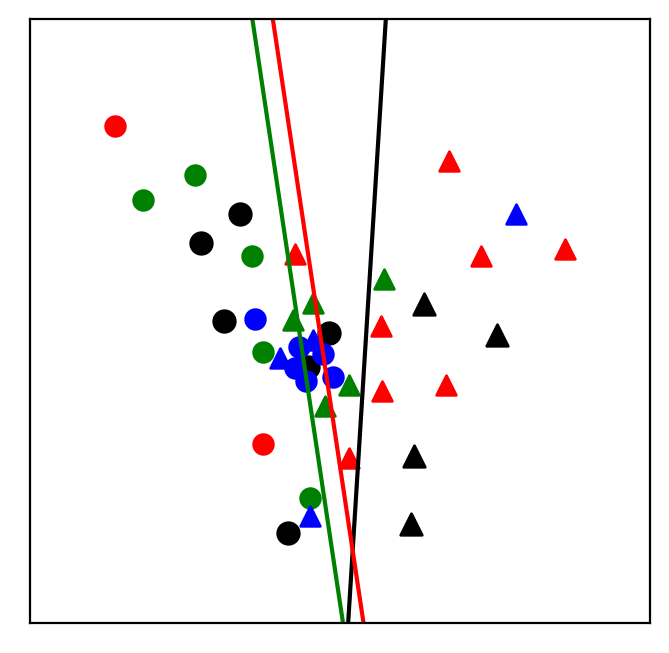

In [20]:
X, y = generateData_twoPills_2D(dataset_size=100)

idx = np.random.choice(X.shape[0], 10, replace=False)

clf = ActiveLearner(estimator=svm.SVC(kernel='linear', probability=True), X_training=X[idx], y_training=y[idx], query_strategy=batch.uncertainty_batch_sampling)
clf_all = svm.SVC(kernel='linear', probability=True)
clf_all.fit(X,y)

mask = np.ones(len(X), bool)
mask[idx] = 0
X_all = X[mask]
y_all = y[mask]

fig = plot_classification(None, clf, X[idx], y[idx], X_all, y_all, clf_all)
fig.tight_layout()
fig.savefig('figures/svm_decision_boundary.png')

([<matplotlib.collections.PathCollection object at 0x7f5f7cba7400>, <matplotlib.collections.PathCollection object at 0x7f5f7cba7a30>], ['Positive', 'Negative'])


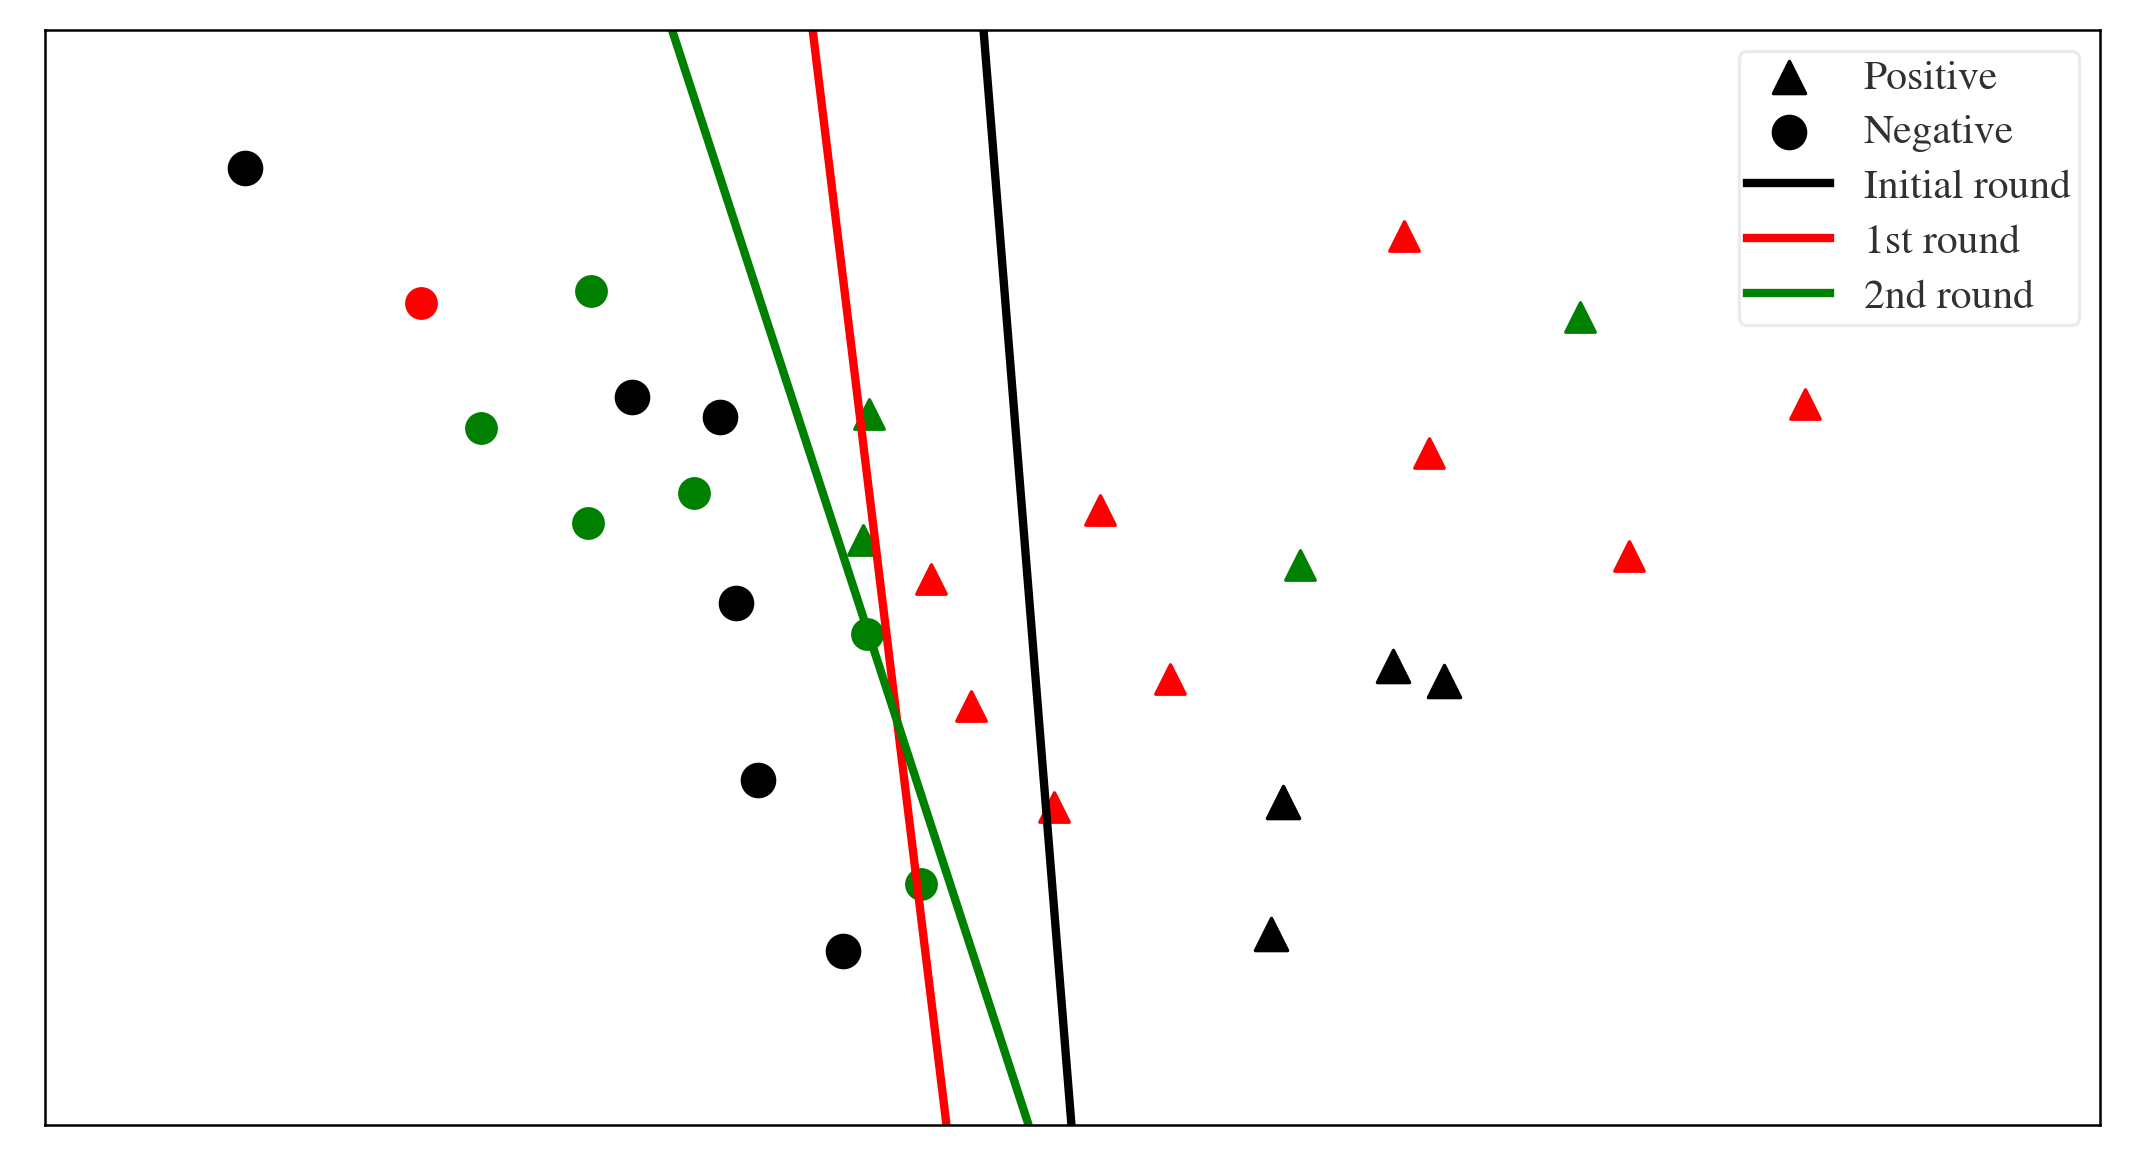

In [78]:
X, y = generateData_twoPills_2D(dataset_size=100)
np.random.seed(1231)

idx = np.random.choice(X.shape[0], 10, replace=False)

clf = ActiveLearner(estimator=svm.SVC(kernel='linear', probability=True), X_training=X[idx], y_training=y[idx], query_strategy=batch.uncertainty_batch_sampling)
clf_all = svm.SVC(kernel='linear', probability=True)
clf_all.fit(X,y)

mask = np.ones(len(X), bool)
mask[idx] = 0
X_all = X[mask]
y_all = y[mask]
with plt.style.context('plt_style.txt'):
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True

    fig, ax = plt.subplots(1, 1, figsize=(7.2, 4.), dpi=300)
    plot_classification(ax, clf, X[idx], y[idx], X_all, y_all, clf_all)
    fig.tight_layout()
    fig.savefig('figures/svm_decision_boundary.png')

* Started with black points initially
* Drew red decision boundary
* Queried red points
* Drew green decision boundary
* Queried green points
* Drew green decision boundary
* Queried blue points
* Drew blue decision boundary

## Poison Query Synthesis

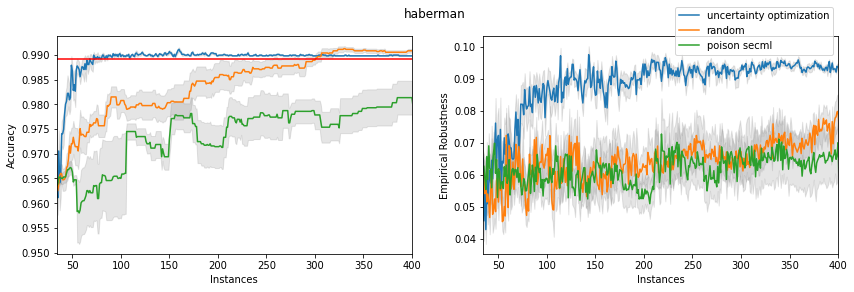

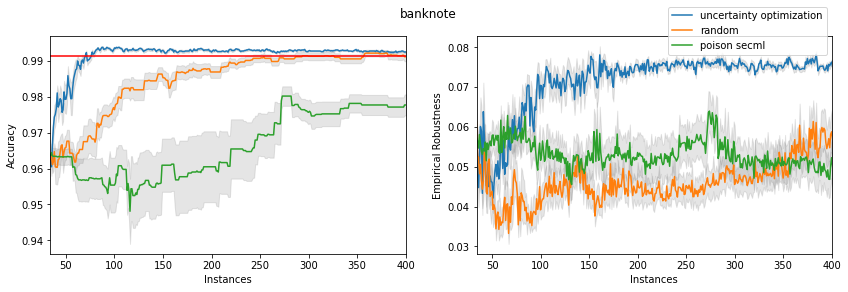

In [17]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0), solver_params=solver_params),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv", index_col=0)
        stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv", index_col=0)
        
        for i, ax in enumerate(axes.flatten()):
            if i == 1:
                i = 3
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
            ax.set_xlim(34, 400)
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend(bbox_to_anchor=(0.9,1))
    fig.savefig(f'figures/poison_query_synthesis_{dataset_name}.png')

In [11]:
metrics['x'][0]

34.0